In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.16.44:43187")
client

Client Scheduler: tcp://10.32.16.44:43187 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 20 Cores: 40 Memory: 230.00 GB


# Comparing ECCO an WOA datasets
for model validation

# ECCO

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
ds = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-ecco-eccov4r3/eccov4r3'), consolidated=True)

In [4]:
ds_ll = faces_dataset_to_latlon(ds)
ds_ll_drop = ds_ll.drop(['i', 'j', 'i_g', 'j_g', 'k', 'k_u', 'k_l', 'k_p1'])

In [5]:
# a trick to make things work a bit faster
coords = ds_ll_drop.coords.to_dataset().reset_coords().roll(i=100, i_g=100)
ds = ds_ll_drop.reset_coords(drop=True).roll(i=100, i_g=100)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
lower_lat = 35 #9
upper_lat = 75 #44
left_lon = 75 #21
right_lon = 167 #120

In [7]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

In [8]:
salt = ds.SALT.isel(**lat_range, **lon_range).mean(dim='time')
temp = ds.THETA.isel(**lat_range, **lon_range).mean(dim='time')

In [9]:
from xhistogram.xarray import histogram
import numpy as np
from matplotlib.colors import LogNorm

In [10]:
salt_bins = np.linspace(32, 35, 100) #0, 35
theta_bins = np.linspace(-2, 4, 100) #-2, 1.2

delta_salt = salt_bins[1] - salt_bins[0]
delta_theta = theta_bins[1] - theta_bins[0]

vol = (coords.hFacC * coords.rA * coords.drF).isel(**lat_range, **lon_range)

In [37]:
vol.sum().values

array(1.1583007e+16, dtype=float32)

In [11]:
salt = ds.SALT.isel(**lat_range, **lon_range)
temp = ds.THETA.isel(**lat_range, **lon_range)

In [12]:
ts_hist = histogram(temp, salt, bins=[theta_bins, salt_bins],
                    weights=vol, dim=['i', 'j', 'k']).rename({'THETA_bin':'theta_bin',
                                                              'SALT_bin':'salt_bin'}) / (delta_salt * delta_theta)
ts_hist

<xarray.DataArray 'histogram_THETA_SALT' (time: 288, theta_bin: 99, salt_bin: 99)>
dask.array<truediv, shape=(288, 99, 99), dtype=float64, chunksize=(1, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1992-01-15 1992-02-13 ... 2015-12-14
  * theta_bin  (theta_bin) float64 -1.97 -1.909 -1.848 ... 3.848 3.909 3.97
  * salt_bin   (salt_bin) float64 32.02 32.05 32.08 32.11 ... 34.92 34.95 34.98

In [13]:
#taking hist mean over `time` takes average (notice the scales are diff in either plots)
ts_hist_mean = ts_hist.mean(dim='time')

Text(0, 0.5, 'Potential Temperature [˚C]')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


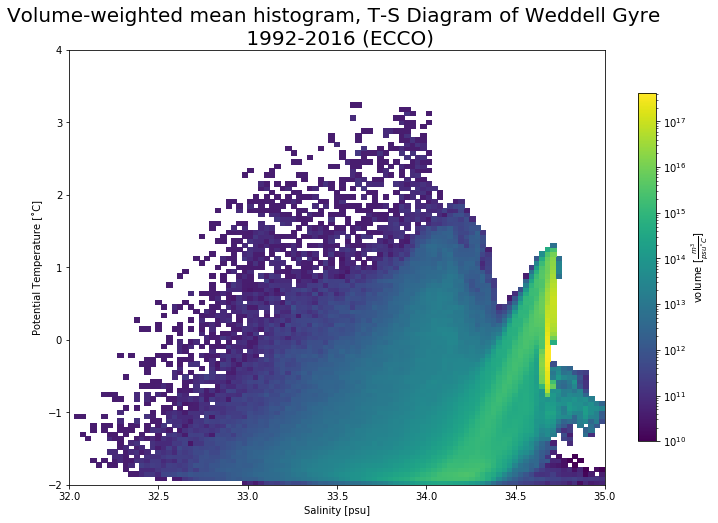

In [14]:
ts_hist_mean.where(ts_hist_mean>0).plot(norm=LogNorm(), figsize=(12,8), cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1992-2016 (ECCO)', fontsize=20)
plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')

# WOA 1981-2010

In [15]:
ds_salt = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/salt')
ds_temp = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/Avg_Decades_1981-2010/temp')
ds_8110 = xr.merge([ds_salt, ds_temp])

In [16]:
lower_lat_woa = -79.88
upper_lat_woa = -59.88
left_lon_woa = -74.88
right_lon_woa = 30.12

In [17]:
#set the boundaries
lat_range_woa = dict(lat=slice(lower_lat_woa, upper_lat_woa))
lon_range_woa = dict(lon=slice(left_lon_woa, right_lon_woa))

In [18]:
temp_8110 = ds_8110.tan.sel(**lat_range_woa, **lon_range_woa).rename('theta')
salt_8110 = ds_8110.san.sel(**lat_range_woa, **lon_range_woa).rename('salt')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


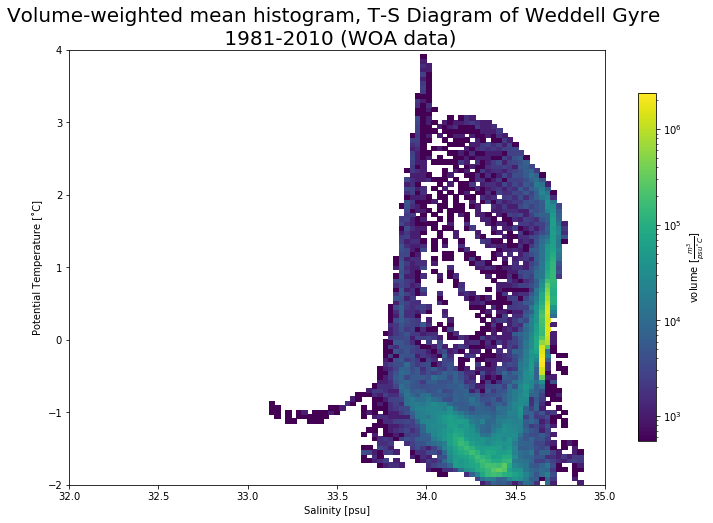

In [20]:
ts_hist_8110 = histogram(temp_8110, salt_8110, bins=[theta_bins, salt_bins]) / (delta_salt * delta_theta)
ts_hist_8110.where(ts_hist_8110>0).plot(norm=LogNorm(), figsize=(12,8), 
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 1981-2010 (WOA data)', fontsize=20);

## Difference

In [21]:
ts_hist_mean

<xarray.DataArray 'histogram_THETA_SALT' (theta_bin: 99, salt_bin: 99)>
dask.array<mean_agg-aggregate, shape=(99, 99), dtype=float64, chunksize=(99, 99), chunktype=numpy.ndarray>
Coordinates:
  * theta_bin  (theta_bin) float64 -1.97 -1.909 -1.848 ... 3.848 3.909 3.97
  * salt_bin   (salt_bin) float64 32.02 32.05 32.08 32.11 ... 34.92 34.95 34.98

In [22]:
ts_hist_8110

<xarray.DataArray 'histogram_theta_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -1.97 -1.909 -1.848 ... 3.848 3.909 3.97
  * salt_bin   (salt_bin) float64 32.02 32.05 32.08 32.11 ... 34.92 34.95 34.98

In [23]:
ts_hist_ecco_8110 = ts_hist_mean - ts_hist_8110
ts_hist_ecco_8110.load()

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.88055131e+10, 5.15146852e+10, 5.81500561e+10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.61332084e+11, 1.28525333e+11, 9.69943783e+10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.88499308e+10, 0.00000000e+00, 4.48405052e+10],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * theta_bin  (theta_bin) float64 -1.97 -1.909 -1.848 ... 3.848 3.909 3.97
  * salt_bin   (salt_bin) float64 32.02 32.05 32.08 32.11 ... 34.92 34.95 34.98

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


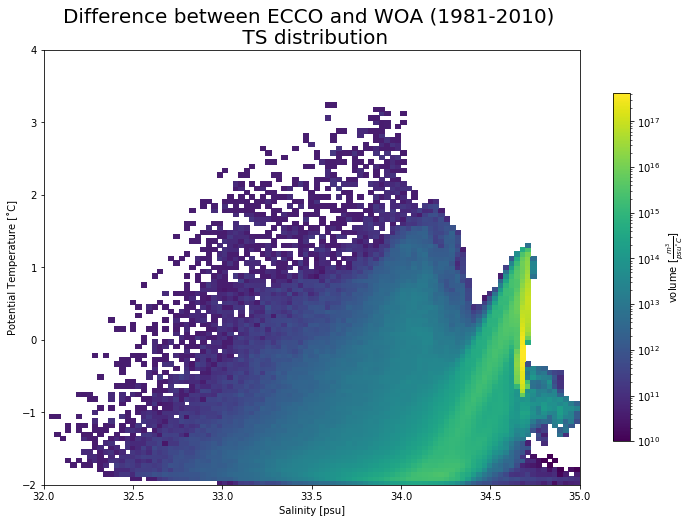

In [24]:
ts_hist_ecco_8110.where(ts_hist_ecco_8110>0).plot(norm=LogNorm(), figsize=(12,8), 
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Difference between ECCO and WOA (1981-2010) \n TS distribution', fontsize=20);

# WOA 2005-2017

In [25]:
ds_salt_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/salt')
ds_temp_0517 = xr.open_dataset('http://apdrc.soest.hawaii.edu:80/dods/public_data/WOA/WOA18/1_deg/annual/2005-2017/temp')
ds_0517 = xr.merge([ds_salt_0517, ds_temp_0517])

In [26]:
temp_0517 = ds_0517.tan.sel(**lat_range_woa, **lon_range_woa).rename('theta')
salt_0517 = ds_0517.san.sel(**lat_range_woa, **lon_range_woa).rename('salt')

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


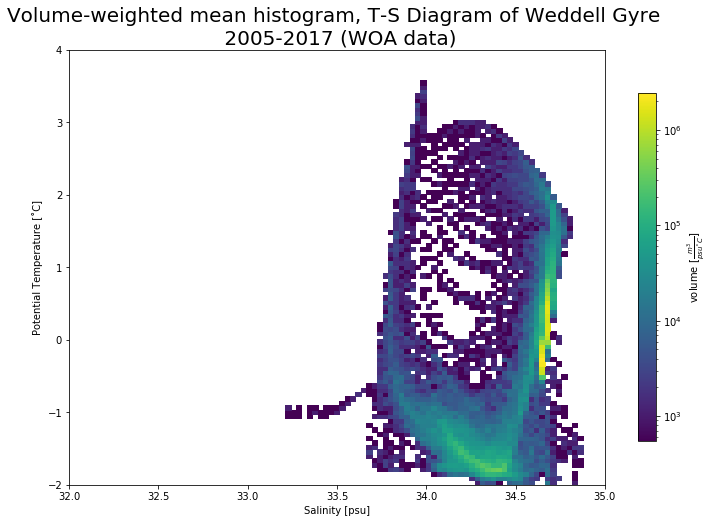

In [27]:
ts_hist_0517 = histogram(temp_0517, salt_0517, bins=[theta_bins, salt_bins]) / (delta_salt * delta_theta)
ts_hist_0517.where(ts_hist_0517>0).plot(norm=LogNorm(), figsize=(12,8), 
                                        cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Volume-weighted mean histogram, T-S Diagram of Weddell Gyre \n 2005-2017 (WOA data)', fontsize=20);

## Difference

In [28]:
ts_hist_mean

<xarray.DataArray 'histogram_THETA_SALT' (theta_bin: 99, salt_bin: 99)>
dask.array<mean_agg-aggregate, shape=(99, 99), dtype=float64, chunksize=(99, 99), chunktype=numpy.ndarray>
Coordinates:
  * theta_bin  (theta_bin) float64 -1.97 -1.909 -1.848 ... 3.848 3.909 3.97
  * salt_bin   (salt_bin) float64 32.02 32.05 32.08 32.11 ... 34.92 34.95 34.98

In [29]:
ts_hist_0517

<xarray.DataArray 'histogram_theta_salt' (theta_bin: 99, salt_bin: 99)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * theta_bin  (theta_bin) float64 -1.97 -1.909 -1.848 ... 3.848 3.909 3.97
  * salt_bin   (salt_bin) float64 32.02 32.05 32.08 32.11 ... 34.92 34.95 34.98

In [30]:
ts_hist_ecco_0517 = ts_hist_mean - ts_hist_0517
ts_hist_ecco_0517.load()

<xarray.DataArray (theta_bin: 99, salt_bin: 99)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.88055131e+10, 5.15146852e+10, 5.81500561e+10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.61332084e+11, 1.28525333e+11, 9.69943783e+10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.88499308e+10, 0.00000000e+00, 4.48405052e+10],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * theta_bin  (theta_bin) float64 -1.97 -1.909 -1.848 ... 3.848 3.909 3.97
  * salt_bin   (salt_bin) float64 32.02 32.05 32.08 32.11 ... 34.92 34.95 34.98

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


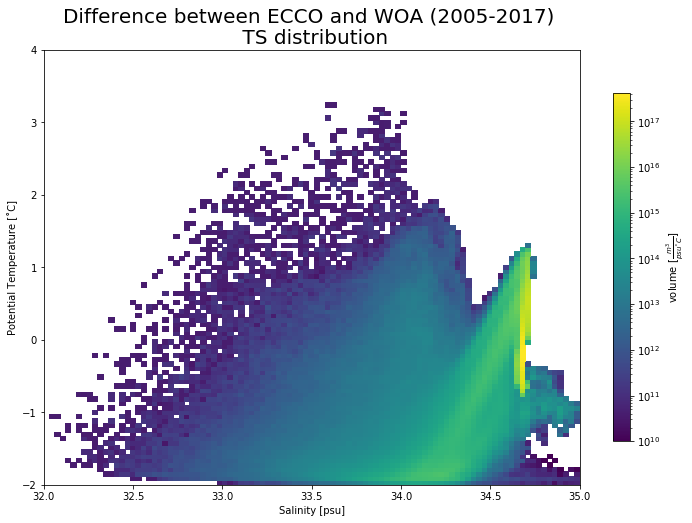

In [31]:
ts_hist_ecco_0517.where(ts_hist_ecco_0517>0).plot(norm=LogNorm(), figsize=(12,8), 
                              cbar_kwargs={'shrink':0.8, 'label': r'volume [$\frac{m^3}{psu ˚C}$]'})

plt.xlabel('Salinity [psu]')
plt.ylabel('Potential Temperature [˚C]')
plt.title('Difference between ECCO and WOA (2005-2017) \n TS distribution', fontsize=20);